## Building data pipelines with the ImFusion Python SDK

The imfusion.machinelearning.Dataset class offers a high-level API for constructing a data loading and processing pipeline.
After specifying the file specification upon instantiation, the pipeline can be customized using a set of decorator methods.
Each such method adds a modular processing step to the pipeline. It also returns a reference to `self` so the entire pipeline can be conveniently specified using method chaining. 

In [1]:
import imfusion
import imfusion.machinelearning as ml
from pathlib import Path

from imfusion_sdk.demo_utils import mpr_plot, unzip_folder

unzipped_folder = unzip_folder('data/pet-ct-rtstruct.zip')

Public beta build of ImFusion Python SDK. Not for commercial use.


In [2]:
# The data we are going to use for this example
ct_file = Path('data/pet-ct-rtstruct/ct.imf').absolute().as_posix()
target_file = Path('data/pet-ct-rtstruct/bones.imf').absolute().as_posix()

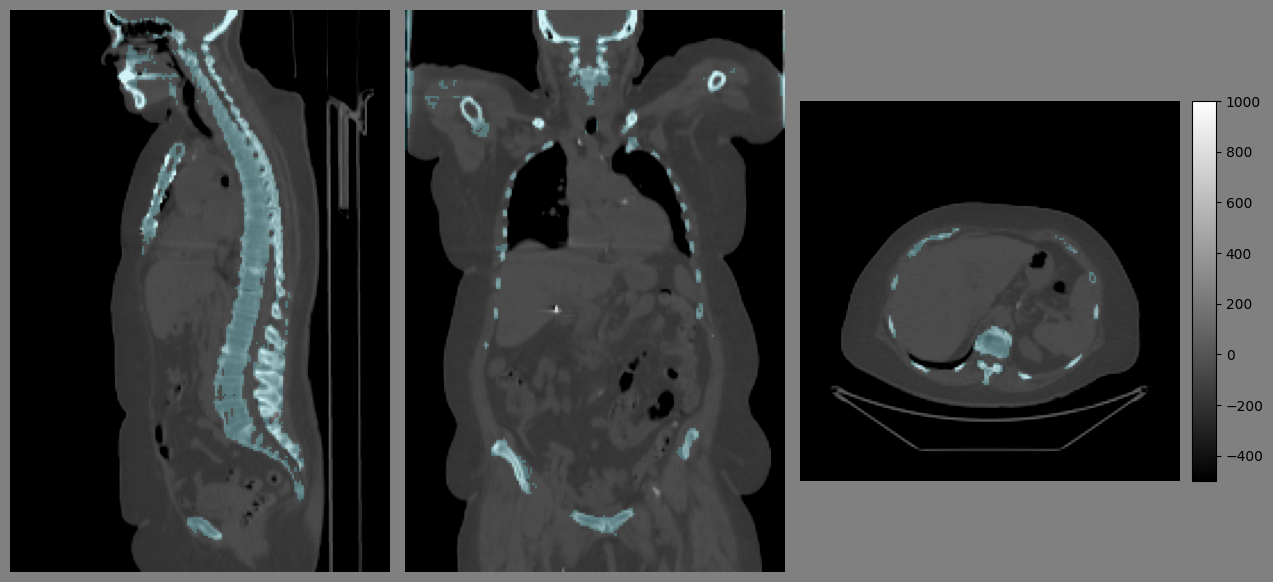

In [3]:
# Loading the images just so we can visualize them here
# This has no relevance to the pipeline that we will construct below
mpr_plot(
    imfusion.load(ct_file)[0][0],
	labels=imfusion.load(target_file)[0][0],
    vmin=-500,
    vmax=1000,
    label_alpha=0.2
)


The class representing our data-loading pipeline is [imfusion.machinelearning.Dataset](https://docs.imfusion.com/python/reference.html#imfusion.machinelearning.Dataset).
We can construct an instance by giving it a specification that details how to load data from disk.
Afterward, we can attach additional processing using its methods. These also permit method-chaining.
Among them, [preprocess](https://docs.imfusion.com/python/reference.html#imfusion.machinelearning.Dataset.preprocess) allows to leverage [Operations](https://docs.imfusion.com/python/ml_op_bindings.html) to apply all kinds of transformations on the data.

In [4]:
# Since each file may contain multiple images we have to specify a mapping in our file loading specification
# Each mapping takes the form <image-index-in-file> -> <field-name-in-the-data-item-after-loading>
ct_loading_spec = ({0: 'images'}, [ct_file])
target_loading_spec = ({0: 'target'}, [target_file])

# We construct the dataset by passing it a list of file loading specifications
# Optionally, we can also enable additional logging by setting verbose=True
dataset = ml.Dataset([ct_loading_spec, target_loading_spec], verbose=True)

# Now we can build the pipeline using method chaining
dataset = (
	dataset
	.preprocess([	# applies some deterministic processing to every loaded item
		ml.MarkAsTargetOperation(apply_to=["target"]),
		ml.MakeFloatOperation(),
		ml.NormalizePercentileOperation(min_percentile=0.01, max_percentile=0.99),
		ml.ResampleOperation(resolution=[3]*3, preserve_extent=True),
	])
	.memory_cache() # caches preprocessed items in memory, so we don't need to repeat the steps before
	.repeat(1_000)	# repeats the entire pipeline (we use it here since we are working with only one sample)
	.preprocess([	# add some non-deterministic augmentation, by default all are applied but this can be tuned with the `probability` kw-argument
		ml.RandomRotationOperation(angles_range=[10,10,10]),
		ml.RandomGammaCorrectionOperation(random_range=0.2),
		ml.BakeTransformationOperation(),
	])
	.sample(		# samples a region of interest from the item
		samplers=[  # we can specify multiple sampling strategies which will be chosen at random
            ml.RandomROISampler(roi_size=[128]*3),	# this samples a random 128³ sub-region
        	ml.LabelROISampler(roi_size=[128]*3, labels_values=[1], sample_boundaries_only=True)	# similar to RandomROISampler but ensures that the target is visible
        ],
        weights=[1, 2]  # specifies the weights for the random choice of the sampling strategy
	) 
	.batch(2)		# batches inputs in pairs
)

Now that we have created the pipeline we can get items from it using `iter` / `next` (or `for`-loops which use those implicitly)
The output of the pipeline is always a [DataItem](https://docs.imfusion.com/python/reference.html#imfusion.machinelearning.DataItem), which is a mapping from a string identifier to a piece of processed data.

In [5]:
imfusion.set_log_level(2)
sample = next(dataset)
sample

[ML.FileReader] Loading /data/imfusion/github/public-python-demos/imfusion_sdk/data/pet-ct-rtstruct/ct.imf
[ML.FileReader] Loading /data/imfusion/github/public-python-demos/imfusion_sdk/data/pet-ct-rtstruct/bones.imf
[ML.FileReader] next() executed in 30.331 ms
[ML.OperationsSequence] MarkAsTargetOperation executed in 0.003 ms
[ML.OperationsSequence] MakeFloatOperation executed in 15.070 ms
[ML.OperationsSequence] NormalizePercentileOperation executed in 31.214 ms
[ML.OperationsSequence] ResampleOperation executed in 1.872 ms
[ML.CacheDataLoader] next() executed in 115.126 ms
[ML.RepeatDataLoader] next() executed in 0.001 ms
[ML.OperationsSequence] RandomRotationOperation executed in 0.084 ms
[ML.OperationsSequence] RandomGammaCorrectionOperation executed in 48.945 ms
[ML.OperationsSequence] BakeTransformationOperation executed in 2.792 ms
[ML.MapDataLoader] next() executed in 60.063 ms
[ML.CacheDataLoader] next() executed in 11.901 ms
[ML.CacheDataLoader] next() executed in 0.015 ms
[

imfusion.machinelearning.DataItem({images: imfusion.machinelearning.ImageElement(imfusion.SharedImageSet(size: 2, [
    imfusion.SharedImage(FLOAT width: 128 height: 128 slices: 128 spacing: 2.95301x2.98916x2.96379 mm),
    imfusion.SharedImage(FLOAT width: 128 height: 128 slices: 128 spacing: 2.97872x2.97387x2.98356 mm)
])), target: imfusion.machinelearning.ImageElement(imfusion.SharedImageSet(size: 2, [
    imfusion.SharedImage(UBYTE width: 128 height: 128 slices: 128 spacing: 2.95301x2.98916x2.96379 mm),
    imfusion.SharedImage(UBYTE width: 128 height: 128 slices: 128 spacing: 2.97872x2.97387x2.98356 mm)
]))})

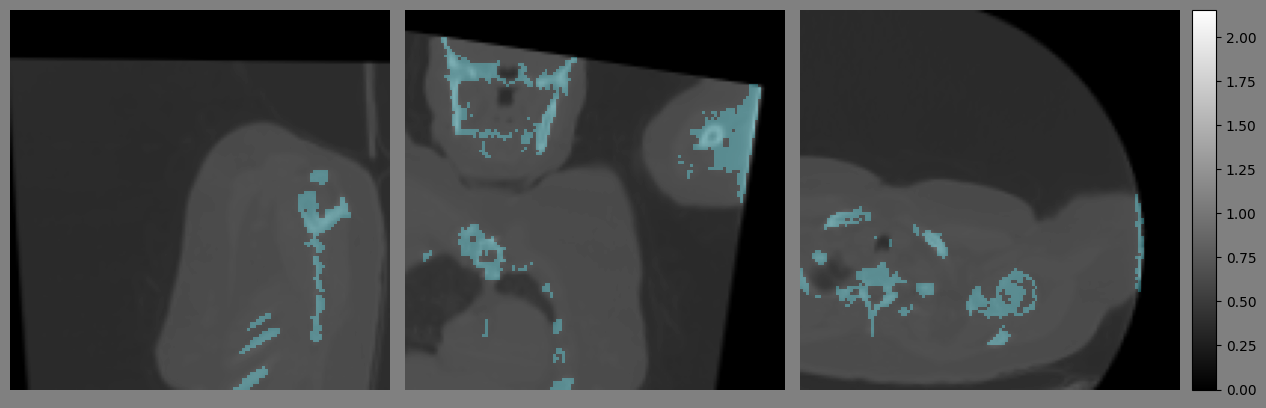

In [6]:
mpr_plot(
    sample["images"].content[0],
    labels=sample["target"].content[0],
)

Notice how the loading is much faster the second time due to the caching.

In [7]:
next(dataset)

[ML.CacheDataLoader] next() executed in 3.114 ms
[ML.CacheDataLoader] next() executed in 0.019 ms
[ML.RepeatDataLoader] next() executed in 0.001 ms
[ML.OperationsSequence] RandomRotationOperation executed in 0.073 ms
[ML.OperationsSequence] RandomGammaCorrectionOperation executed in 29.698 ms
[ML.OperationsSequence] BakeTransformationOperation executed in 8.223 ms
[ML.MapDataLoader] next() executed in 3.638 ms
[ML.CacheDataLoader] next() executed in 14.520 ms
[ML.CacheDataLoader] next() executed in 0.020 ms
[ML.RepeatDataLoader] next() executed in 0.001 ms
[ML.OperationsSequence] RandomRotationOperation executed in 0.077 ms
[ML.OperationsSequence] RandomGammaCorrectionOperation executed in 26.911 ms
[ML.OperationsSequence] BakeTransformationOperation executed in 4.296 ms
[ML.MapDataLoader] next() executed in 58.829 ms
[ML.BatchDataLoader] next() executed in 0.347 ms
[ML.Dataset] next() executed in 149.924 ms


imfusion.machinelearning.DataItem({images: imfusion.machinelearning.ImageElement(imfusion.SharedImageSet(size: 2, [
    imfusion.SharedImage(FLOAT width: 128 height: 128 slices: 128 spacing: 2.99158x2.97937x2.98755 mm),
    imfusion.SharedImage(FLOAT width: 128 height: 128 slices: 128 spacing: 2.98989x2.99771x2.98782 mm)
])), target: imfusion.machinelearning.ImageElement(imfusion.SharedImageSet(size: 2, [
    imfusion.SharedImage(UBYTE width: 128 height: 128 slices: 128 spacing: 2.99158x2.97937x2.98755 mm),
    imfusion.SharedImage(UBYTE width: 128 height: 128 slices: 128 spacing: 2.98989x2.99771x2.98782 mm)
]))})

Since we are working with ImFusion Data subclasses, attached metadata is persistent through the entire pipline.
Some is even generated by the pipeline itself to facilitate debugging and compliance.

For example the `ProcessingRecordDataComponent` records all operations (and their configuration) that have acted on this piece of data.

In [8]:
sample['images'].components.processing_record.configuration().asdict()

{'0/0': {'MakeFloatOperation/0': {'device': 'GPUIfOpenGl',
   'processing_policy': 0,
   'error_on_unexpected_behaviour': False},
  'NormalizePercentileOperation/0': {'device': 'GPUIfOpenGl',
   'processing_policy': 0,
   'error_on_unexpected_behaviour': False,
   'ignore_zeros': False,
   'clamp_values': False,
   'max_percentile': 0.990000009536743,
   'min_percentile': 0.00999999977648258},
  'ResampleOperation/0': {'device': 'GPUIfOpenGl',
   'processing_policy': 1,
   'error_on_unexpected_behaviour': False,
   'preserve_extent': True,
   'resolution': '3 3 3 '},
  'RotationOperation/0': {'device': 'GPUIfOpenGl',
   'processing_policy': 1,
   'error_on_unexpected_behaviour': False,
   'apply_now': False,
   'adjust_size': False,
   'angles': '0.642805099487305 -8.88762187957764 -4.93088293075562 '},
  'GammaCorrectionOperation/0': {'device': 'GPUIfOpenGl',
   'processing_policy': 0,
   'error_on_unexpected_behaviour': False,
   'gamma': 0.89698338508606},
  'BakeTransformationOpera

We can use this to verify that the target was indeed not modified by our random augmentations.

In [9]:
sample['target'].components.processing_record.configuration().asdict()

{'0/0': {'ResampleOperation/0': {'device': 'GPUIfOpenGl',
   'processing_policy': 1,
   'error_on_unexpected_behaviour': False,
   'preserve_extent': True,
   'resolution': '3 3 3 '},
  'RotationOperation/0': {'device': 'GPUIfOpenGl',
   'processing_policy': 1,
   'error_on_unexpected_behaviour': False,
   'apply_now': False,
   'adjust_size': False,
   'angles': '0.642805099487305 -8.88762187957764 -4.93088293075562 '},
  'BakeTransformationOperation/0': {'device': 'GPUIfOpenGl',
   'processing_policy': 1,
   'error_on_unexpected_behaviour': False},
  'LabelROISampler/0': {'device': 'GPUIfOpenGl',
   'processing_policy': 1,
   'error_on_unexpected_behaviour': False,
   'fallback_to_random': True,
   'sample_boundaries_only': True,
   'labels_values': [1],
   'roi_size': '128 128 128 ',
   'padding_mode': 'clamp',
   'label_padding_mode': 'clamp'}}}

Another example of metadata that we would like to keep throughout the pipeline is licensing information of the data.

In this example the loaded data already comes with a `DatasetLicenseComponent`

In [10]:
sample['images'].components.dataset_license

DatasetLicenseComponent(infos=[
	
DatasetLicenseComponent.DatasetInfo(
	name=The Clinical Proteomic Tumor Analysis Consortium Uterine Corpus Endometrial Carcinoma Collection (CPTAC-UCEC),
	authors=National Cancer Institute Clinical Proteomic Tumor Analysis Consortium (CPTAC),
	website=https://doi.org/10.7937/K9/TCIA.2018.3R3JUISW,
	license=CC BY 3.0,
	attribution_required=true,
	commercial_use_allowed=true
),
	
DatasetLicenseComponent.DatasetInfo(
	name=The Clinical Proteomic Tumor Analysis Consortium Uterine Corpus Endometrial Carcinoma Collection (CPTAC-UCEC),
	authors=National Cancer Institute Clinical Proteomic Tumor Analysis Consortium (CPTAC),
	website=https://doi.org/10.7937/K9/TCIA.2018.3R3JUISW,
	license=CC BY 3.0,
	attribution_required=true,
	commercial_use_allowed=true
)	])

The data can then be easily converted to torch and then fed into your ML model (but this loses any metadata).
(The cells below only work if you also install the `torch` package: `pip install 'torch==2.2.2`. We did not include it  in the requirements due to the massive file size) 

In [11]:
tensor = sample['images'].torch(device='cpu')
tensor.shape

torch.Size([2, 1, 128, 128, 128])

And we can easily convert torch tensors back to ImFusion types.
If we provide an existing image as a template, we can also copy over its metadata.
This comes in handy when we want to e.g. convert the output of a ML model back to a SharedImageSet and retain the metadata of the input to the model.

In [12]:
roundtrip = imfusion.SharedImageSet.from_torch(tensor, get_metadata_from=sample['images'].to_sis())
assert roundtrip.components.dataset_license == sample['images'].components.dataset_license
roundtrip

imfusion.SharedImageSet(size: 2, [
    imfusion.SharedImage(FLOAT width: 128 height: 128 slices: 128 spacing: 2.95301x2.98916x2.96379 pix),
    imfusion.SharedImage(FLOAT width: 128 height: 128 slices: 128 spacing: 2.97872x2.97387x2.98356 pix)
])